# How to predict catastrophic events ?

## Introduction 

At the end of that short but preciser tutorial, you'll understand what is a GEV (Generalized extreme value distribution) and how to fit it on your data in python. 

What we need to think about before speaking of extreme values statistics, is that in general statistics focus on average values and observable phenomenoms, for which we **do have datas**. Extreme values statistics is different from "average" statistics in this regard, indeed as we will see, we here try to model something for which **we have no data!** You will see soon what we mean by that. Before getting there I want to show you why extreme values modelling is an actual problem, of high interest for insurance companies and public services. Let's start with two examples.

### <center> Montpellier, France, 2014
**3 hours of rain = 50% of total annual average.** *Montpellier is not known to be a city with a high annual rain level, located in the dry location of Provence, therefore if we look at the average value we have a very common one. But it is not excluded that sometimes, rarely, very high values appear, as we can see:*

<img align="center" src="https://s1.lemde.fr/image2x/2014/10/07/0x0/4501632_5_f1d0_a-picture-taken-on-october-7-2014-shows-a_98f1f199a7769f5add31267568c48d85.jpg" style="width: 700px;"/>
<br>

### <center> Saltina river in Brigue, Switzerland, 1993
**Unprecedented measured flows and precipitations in the twentieth century**.
*Same problem here, this rivers has reasonable flows in average, but sometimes the flow can be exceptional.*
<img align="center" src="http://www.planat.ch/uploads/pics/p0032_01.jpg" style="width: 600px;"/>
<br>

### <center> Number of natural catastrophes since 1980 is growing 
**Those "extreme" events tends to become more and numerous those days, and make extreme value analysis "popular".**
<img align="center" src="https://cdn.static-economist.com/sites/default/files/images/2017/08/blogs/graphic-detail/20170902_woc210.png" style="width: 600px;"/>
<br>


### <center> Some could wonder what statistical model shall we use to predict a Nadal loss at Roland Garros 

<img align="center" src="https://www.freebetreview.com.au/Images/blog/rafael-nadal-french-open-record-infographic.png" style="width: 600px;"/>
<br>
<center> (Almost) just kidding

## Question: What if we would like to quantify the probability of such events ?

As we said the particularity of the extreme value analysis is not to model an average phenomenom but an extreme phenomenom.

In order to understand what we mean by that, let's work with the Nidd river dataset here : https://www.stat.auckland.ac.nz/~wild/data/Rdatasets/csv/evir/nidd.thresh.csv, it contains $n=154$ trimestrial measures of the river's flows (in $m³/s$), over a period of 38.5 years (source: Natural Environment Research, 1975). 

Let's plot a histogram of the data.


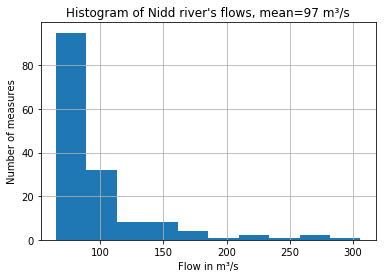

In [122]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


df = pd.read_csv('data/nidd.thresh.csv')
df = df['x']
df.hist();
plt.xlabel('Flow in m³/s');
plt.ylabel('Number of measures');
plt.title('Histogram of Nidd river\'s flows, mean=%d m³/s' % df.mean());

We see that most flows are under $80$ $m³/s$, a significant part is under $100$ $m³/s$, but we also see that even if the flows are in general low, it can also become $300$ $m³/s$ high.

This is typically a problem where we cannot use the average value to represent anything, since most flows are under $80$ $m³/s$, and some are very high.

**Warm-up questions: what is the probability to observe a flow superior to $160$ $m³/s$ ? Then $255$ $m³/s$ ?**

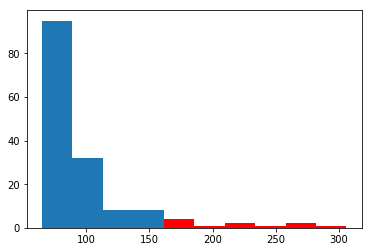

In [210]:
n, bins, patches = plt.hist(df)
for i, x in enumerate((bins > 160)):
    if x and i < len(bins)-1:
        patches[i].set_fc('r')

plt.show()

The step for the last bin represent one flow, this way we even can count visually the population in all the red bins :

$$P(X > 160) \simeq nb(X_{i} > 160) / n = 11/154 = 1/14$$

Using our empiric data we compute this way the probability to have a flow superior to $160$ $ m³/s$, which tells us that we have a flow of this type in average every $3.5$ years.

Nothing unusual yet, right ?...


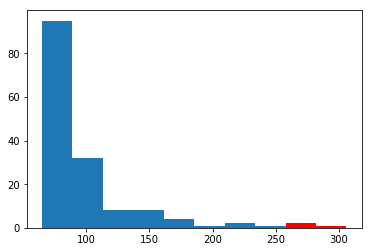

In [211]:
n, bins, patches = plt.hist(df)
for i, x in enumerate((bins > 255)):
    if x and i < len(bins)-1:
        patches[i].set_fc('r')
        
plt.show()

Histogram:
$$P(X > 255) \simeq nb(X_{i} > 255) / n = 3/154 $$

Here again we can answer (hardly) that we therefore have a flow superior to $255$ $m³/s$ in average every $12$,$8$ years.

Ok enough played, let's come to the annoying question :

**"You have no way to answer" question: Now, what is the probability to observe such a flow superior to $400$ $m³/s$ ?**

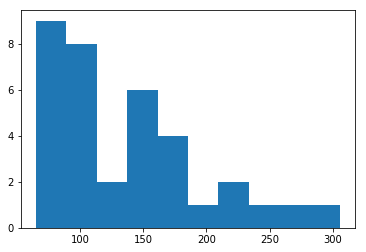

In [59]:
n, bins, patches = plt.hist(df)
for i, x in enumerate((bins > 400)):
    if x and i < len(bins)-1:
        patches[i].set_fc('r')
        
plt.show()

Histogram:
$$P(X > 400) \simeq nb(X_{i} > 400) / n = 0 $$

The answer is not satisfying, because it's surely not "impossible" to observe a flow superior to $400$ $m³/s$.

## Partial Conclusion : we cannot estimate the probability of such a flow with the histogram!

And now we precisely get to what we talked about before, we want to compute the probability of an event for which we have absolutely no data, I hope this is clear now. In statistical modelling, usually, we train an algorithm with a dataset that is supposed to have the same distribution as the testing data, in other words we have datas for what we want to model. Extreme value theory comes into play here:

- **"Classic" statistics doesn't allow to compute probabilities such that $P(X > x)$ when $x$ is beyond the maximum of our observations.**


- **Hopefully Extreme value theory gives us tools to extrapolate beyond our datas.**

A "famous" joke illustrates this problematic: during the night, someone is squatting at the foot of a lamppost, and a passerby asks him: "What are you doing?" "I'm looking for my keys." "Are you certain that you lost them around the lamppost?", asks again the passerby. "No, but, in fact, that's the only lighted place."



Extreme value statistics is kind of like this joke, we want to make statistics where there is no light, where there is no data.

## Theory: Extreme values theorem / Implementation: scipy.stats.genextreme

The extreme values theorem can be seen as the analog of the central limit theorem.
For a random variable $X$ and it's maximum over n observations: $X_{n,n}$. 



Under general conditions on the distribution of X, there is three parameters
$a_{n}$, $b_{n}$ and $\gamma$ such that :
   $$\lim_{n -> +\infty} P(\frac{X_{n,n} - a_{n}}{b_{n}} \leq x) = H_{\gamma}(x)$$
   where:
$$ H_{\gamma}(x) = \begin{cases}
                \exp(-\exp(-x))            &\text{for } \gamma = 0\\
                \exp(-(1+\gamma x)^{-1/\gamma}_{+})   &\text{for }
                                                        \gamma != 0
              \end{cases}
$$
   
   with $y_{+} = max(0,y)$.
   
Useful vocabulary:
 - $H_{\gamma}$ is the **generalized extreme value (GEV) distribution**.
 - $\gamma$ is the shape parameter
 - $a_{n}$ and $b_{n}$ are scaling parameters.
 
With different values of $\gamma$ there is a type I, type II and type III GEV, also called the Gumbel ($\gamma=0$), Fréchet ($\gamma >0$) and Weibull ($\gamma <0$) distributions.

If you have a random variable $X$ and study the distribution of it's maximum over a number of samples $X_{n,n}$, this distribution must belong and must "fall" in the domain of attraction of one of these 3 types of GEV. 
 
(More here : https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution.)

**We will use the genextreme class from scipy**

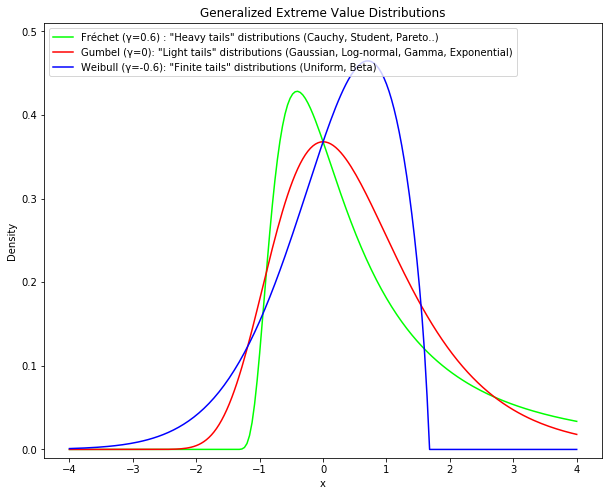

In [114]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import genextreme 

plt.figure(figsize=(10,8)) 
x = np.linspace(-4, 4, 201) 
#Please notice that in genextreme the shape parameter (gamma) equals to -gamma in our equations here
plt.plot(x, genextreme.pdf(x, -0.6), color='#00FF00', label='Fréchet (\u03B3=0.6) : "Heavy tails" distributions\
 (Cauchy, Student, Pareto..)') 
plt.plot(x, genextreme.pdf(x, 0.0), 'r', label='Gumbel (\u03B3=0): "Light tails" distributions\
 (Gaussian, Log-normal, Gamma, Exponential)') 
plt.plot(x, genextreme.pdf(x, 0.6), 'b', label='Weibull (\u03B3=-0.6): "Finite tails" distributions\
 (Uniform, Beta)') 
plt.ylim(-0.01, 0.51) 
plt.legend(loc='upper left') 
plt.xlabel('x') 
plt.ylabel('Density') 
plt.title('Generalized Extreme Value Distributions') 
plt.show() 

Let's use again our dataset of Nidd River, we will fit a GEV on it and estimate extreme quantiles.
In pratice we will estimate the three parameters $\gamma$, $a_{n}$ and $b_{n}$ such that:
$$P(X_{n,n} \leq x) \simeq H_{\gamma}(\frac{x-a_{n}}{b_{n}})$$

So first we need to turn our trimestrial data, that is our observations of $X$ into observations of X_{n,n}, lets say yearly maximums, we will create a vector of observations by taking the maximum flow for each year:

In [149]:
for i in range(0, int(df.shape[0]/4)):
    if i == 0:
        df_max = df.iloc[4*i:4*i+4].max()
    else:
        df_max = np.append(df_max, df.iloc[4*i:4*i+4].max())

(array([ 9., 10.,  3.,  7.,  4.,  1.,  0.,  2.,  1.,  1.]),
 array([ 76.74 ,  99.641, 122.542, 145.443, 168.344, 191.245, 214.146,
        237.047, 259.948, 282.849, 305.75 ]),
 <a list of 10 Patch objects>)

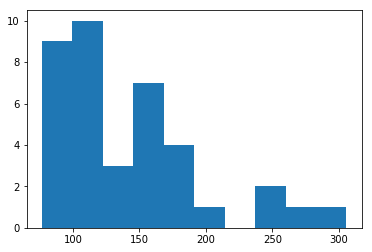

In [151]:
plt.hist(df_max)

In [163]:
shape, loc, scale = genextreme.fit(df_max) 

In [212]:
-shape

0.3284055812905212

This shape parameters tells us that the GEV is a Fréchet type, with a heavy tails, which means our river's flow can sometimes be very big, we better be careful and construct strong flood protections.

We can plot the fitted distribution to see that it makes sense

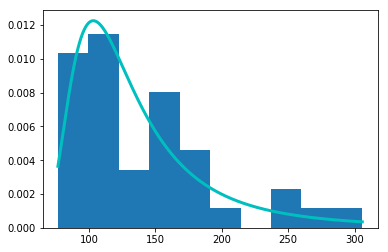

In [154]:
plt.hist(df_max, normed=True); 

x = np.linspace(df_max.min(), df_max.max(), 1000) 
y = genextreme.pdf(x, shape, loc, scale) 
plt.plot(x, y, 'c', linewidth=3);

**We can now calculate the probability that the river's flow exceeds 350 $m^3/s$:**
Indeed, because the observations of $X$ that we have are independant, hence:
$P(X_{n,n} \leq x) = F^{n}(x)$
and from the extreme value theorem this means $F(x) \simeq H_{\gamma}^{1/n}(\frac{x-a_{n}}{b_{n}})$, taking the log and developping around $\log(1+u)$ gives :
$P(X\geq x) \simeq -\frac{1}{n}\log H_{\gamma}(\frac{x-a_{n}}{b_{n}})$
Therefore we now have an approximation of the survival function in tail:

$$ \hat{F}(x) = P(X\geq x) \simeq \begin{cases}
                \frac{1}{n}[1+\gamma(\frac{x-a_{n}}{b_{n}})]^{-1/\gamma}        &\text{for } \gamma != 0\\
                \frac{1}{n}\exp(-(\frac{x-a_{n}}{b_{n}}))   &\text{for }
                                                        \gamma = 0
              \end{cases}
$$

In [185]:
def surv(x, n, shape, loc, scale):
    if shape != 0:
        surv = 1/n * (1 - shape*(x-loc)/scale) ** (1/shape)
    else:
        surv = 1/n * np.exp(-(x-loc)/scale)
    return surv

In [207]:
surv(400, 4, shape, loc, scale)

0.003669861860990634

In [209]:
1/0.004/4

62.5

So the probability that the trimestrial flow will be greater than $400$ $m³/s$ is  about 0.004, which means one trimester in 250, which means one time in 62.5 years! *Instead of "never" before*

We can also answer questions like : what is the river's flow that we expect to surpass every century, because we also have the inverse of the survival function :

$$ \hat{F}^{-1}(x)\simeq \begin{cases}
                a_{n} + \frac{b_{n}}{\gamma}[(np)^{-\gamma} - 1]         &\text{for } \gamma != 0\\
                a_{n} - b_{n}\log(np)   &\text{for }
                                                        \gamma = 0
              \end{cases}
$$

In [203]:
def invsurv(p, n, shape, loc, scale):
    if shape != 0:
        invsurv = loc + scale/-shape * ((n*p)**shape - 1)
    else:
        invsurv = loc - scale * np.log(n*p)
    return invsurv

In [205]:
invsurv(1/400, 4, shape, loc, scale)

451.6079380637543

Here we computed the flow that we would get every 400 trimester, that is every century : $452$ $m³/s$!
It's too bad these guys didn't follow my tutorial before:  <center> 
<img align="center" src="http://www.planat.ch/uploads/pics/p0032_01.jpg" style="width: 600px;"/>
<br>

# Conclusion

**What's new :**
- You now understand the problem with extreme quantiles in classical statistics.
- You now know that there exist an extreme value theorem that looks like CLT that tells us there is 3 types of distributions for the max of any random variable, depending on a shape parameter $\gamma$ : Gumbel, Fréchet, Weibull.
- To fit such a distribution we need a dataset of maximum, and to estimate $\gamma$, $a_{n}$ (loc) and $b_{n}$ (scale).
- We can do that with scipy.stats.genextreme very quickly.
- With it we can compute extreme quantiles and extreme value propabilities where we have no data to learn !!!

**What's not new yet:**
- It's sometimes hard to form a dataset of maximums, there is also a similar alternative with threshold levels instead of maximums, which is easier in general. And the distribution to fit is called a GPD (Generalized Pareto Distribution), that is in scipy.stats.pareto.



**Thanks for your attention !** **God bless you!**